# 数据增广

## 定义与方法

-  增加**已有数据集**，使其变得更有多样性
   - 语言数据里加入不同的**噪音**
   - 改变图片的**颜色和形状**
-  只用于训练集，类似于正则项，测试时无需数据增强
-  常用的数据增强的方法：
   - 翻转
   - 切割：从图片中切割之后变形到固定形状
      - 切割方法：随机高宽比，随机大小，随机位置
   - 颜色：改变色调、饱和度、明亮度
-  做怎么样的数据增强取决于**测试集可能会有怎么样的图片**

## 代码实现

In [46]:
%matplotlib inline
import torch
import torchvision
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
from d2l import torch as d2l

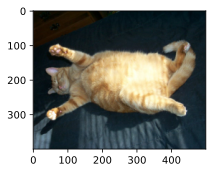

In [47]:
d2l.set_figsize()
img = d2l.Image.open('/home/ly/miniconda3/envs/shiwei/data/cat1.jpg')
d2l.plt.imshow(img);

In [48]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### 随机水平翻转

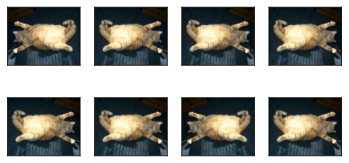

In [49]:
apply(img, torchvision.transforms.RandomHorizontalFlip())# 随机水平翻转

### 随机上下翻转

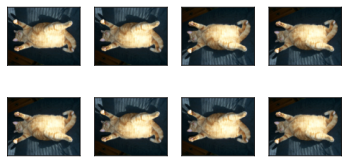

In [50]:
apply(img, torchvision.transforms.RandomVerticalFlip())# 随机上下翻转

### 随机裁剪

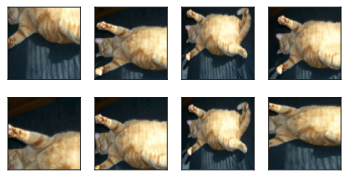

In [51]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
# 随机裁剪输出(200,200)的像素，随机大小10%-100%，随机高宽比1：2-2：1
apply(img, shape_aug)

### 随机改变图像亮度、对比度、饱和度、色调

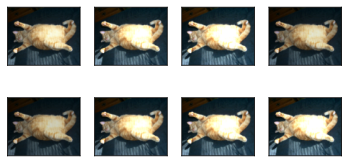

In [52]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))
# 亮度0.5代表上下增加减少0.5，对比度，饱和度，色调

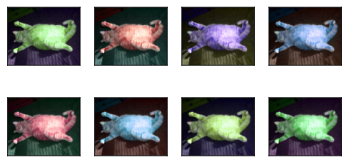

In [53]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

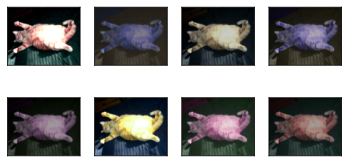

In [54]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### 结合多种图像增广方式

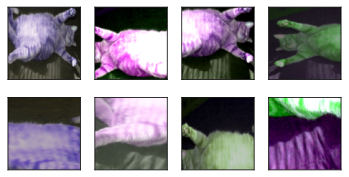

In [55]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
# 混合三种变化方式
apply(img, augs)

## 使用增广进行训练

Files already downloaded and verified


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

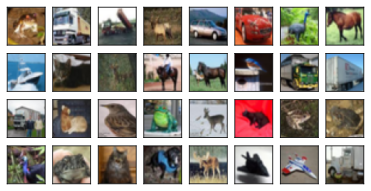

In [56]:
all_images = torchvision.datasets.CIFAR10(train=True, root='/home/ly/miniconda3/envs/shiwei/data', download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [57]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [58]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='/home/ly/miniconda3/envs/shiwei/data',
                                           train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=2)
    return dataloader

In [59]:
train_iter = load_cifar10(True, train_augs, 256)
test_iter = load_cifar10(False, test_augs, 256)

Files already downloaded and verified
Files already downloaded and verified


### 选用自己写的ResNet网络（通道数由1改为3）

In [60]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv == True:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides) 
            #为了和主链的高宽一致，要加stride
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [61]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    # 定义残差块，first_block=False代表了此残差块会将通道加倍，宽高减半；first_block=True代表了此残差块通道与宽高均不变。
    # 即第一个不减半，其余都减半
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,use_1x1conv=True,strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [62]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [63]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10)).cuda()

In [78]:
def train(net, train_iter, test_iter, num_epochs, lr, num_gpus): 
    """用GPU训练模型，模型使用SGD，损失函数是交叉熵，学习率调度器使用基于性能的学习率调度器，采用多GPU设置模型"""
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    net = nn.DataParallel(net) 
    # DataParallel在多个GPU上设置模型
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义一个周期的迭代次数
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, min_lr=1e-5, verbose=True)
    # 定义基于性能的学习率调度器
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'],ylim=[0,2])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)# 训练损失之和，训练准确率之和，样本数
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.cuda(), y.cuda() #训练集的数据移动到device上
            y_hat= net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))# 此处是为了显示图像更方便，拆分等分显示图片
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        lr_scheduler.step(test_acc)
        # 每次epoch进行学习率调整
    print(f'loss {train_l:.3f}, 训练精度{train_acc:.3f}, 测试精度{test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec,平均批次时间 {timer.sum() / num_epochs:.3f} sec',f'在{str(devices)}')

loss 0.561, 训练精度0.804, 测试精度0.722
3126.6 examples/sec,平均批次时间 15.992 sec 在[device(type='cuda', index=0), device(type='cuda', index=1)]


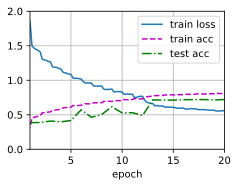

In [80]:
batch_size = 256
lr, num_epochs= 0.05, 20
train(net, train_iter, test_iter, num_epochs, lr, num_gpus=2)